In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip -nc -P ./data/
!unzip -n ./data/rp73yg93n8-1.zip -d ./data/
!unzip -n -q ./data/fruits-360_dataset.zip -d ./data/ 

--2020-11-30 01:40:04--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.57.24
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.57.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418811602 (399M) [application/octet-stream]
Saving to: ‘./data/rp73yg93n8-1.zip’

rp73yg93n8-1.zip    100%[===================>] 399.41M  21.3MB/s    in 19s     

2020-11-30 01:40:24 (20.5 MB/s) - ‘./data/rp73yg93n8-1.zip’ saved [418811602/418811602]

Archive:  ./data/rp73yg93n8-1.zip
  inflating: ./data/fruits-360_dataset.zip  


In [ ]:
import random
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import torch.nn.init as init
from torchsummary import summary

In [ ]:
IMAGE_SIZE = 96
EMBED_SIZE = 128
BATCH_SIZE = 16

EPOCHS = 1000
LR = 0.0004

device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

COLAB_FLG = True

if COLAB_FLG:
    ATTACH_PATH = "/content/drive/My Drive/PyTorch-GAN/"
else:
    ATTACH_PATH = "."
    

SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/EfficientGAN/model/"
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/EfficientGAN/image/image_from_z/"
SAVE_IMAGE_RECONSTRUCT = f"{ATTACH_PATH}/results/EfficientGAN/image/RECONSTRUCT/"

os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_RECONSTRUCT, exist_ok=True)

In [ ]:
train_root = './data/fruits-360/Training/Physalis/'
val_root = './data/fruits-360/Test/Physalis/'

In [ ]:
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)

    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

    def __getitem__(self, idx):

        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [ ]:
transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
        ]
    ),
}

In [ ]:
train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

val_dataset = LoadFromFolder(val_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(256, 512, kernel_size=6, stride=1, bias=False), # 1x1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False), # 1x1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),  
        )

        self.last = nn.Sequential(nn.Conv2d(512, EMBED_SIZE, kernel_size=1, stride=1, bias=False))

    def forward(self, x):

        out = self.main(x)
        out = self.last(out)
        out = out.view(out.size()[0], -1, 1, 1)
        return out

In [ ]:
summary(Encoder().to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,536
       BatchNorm2d-2           [-1, 32, 48, 48]              64
         LeakyReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]          32,768
       BatchNorm2d-5           [-1, 64, 24, 24]             128
         LeakyReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 12, 12]         131,072
       BatchNorm2d-8          [-1, 128, 12, 12]             256
         LeakyReLU-9          [-1, 128, 12, 12]               0
           Conv2d-10            [-1, 256, 6, 6]         524,288
      BatchNorm2d-11            [-1, 256, 6, 6]             512
        LeakyReLU-12            [-1, 256, 6, 6]               0
           Conv2d-13            [-1, 512, 1, 1]       4,718,592
      BatchNorm2d-14            [-1, 51

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(EMBED_SIZE, 256, kernel_size=6, stride=1, padding=0, bias=False),  # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),  # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),  # 96x96
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [ ]:
summary(Generator().to(device), tuple([EMBED_SIZE, 1, 1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 6, 6]       1,179,648
       BatchNorm2d-2            [-1, 256, 6, 6]             512
         LeakyReLU-3            [-1, 256, 6, 6]               0
   ConvTranspose2d-4          [-1, 128, 12, 12]         524,288
       BatchNorm2d-5          [-1, 128, 12, 12]             256
         LeakyReLU-6          [-1, 128, 12, 12]               0
   ConvTranspose2d-7           [-1, 64, 24, 24]         131,072
       BatchNorm2d-8           [-1, 64, 24, 24]             128
         LeakyReLU-9           [-1, 64, 24, 24]               0
  ConvTranspose2d-10           [-1, 32, 48, 48]          32,768
      BatchNorm2d-11           [-1, 32, 48, 48]              64
        LeakyReLU-12           [-1, 32, 48, 48]               0
  ConvTranspose2d-13            [-1, 3, 96, 96]           1,536
             Tanh-14            [-1, 3,

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.x_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 48x48
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=6, stride=1),  # 1x1
        )
        self.z_layer = nn.Sequential(
            nn.Conv2d(EMBED_SIZE, 256, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.2),
        )

        self.last1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=False),
            nn.Dropout2d(p=0.2),
        )
        self.last2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1, stride=1),
        )

    def forward(self, x, z):

        output_x = self.x_layer(x)
        output_z = self.z_layer(z)

        concat_x_z = torch.cat((output_x, output_z), 1)
        output = self.last1(concat_x_z)

        feature = output.view(output.size()[0], -1)

        output = self.last2(output)
        output = F.sigmoid(output)
        return output.squeeze(), feature

In [ ]:
summary(Discriminator().to(device), [(3, IMAGE_SIZE, IMAGE_SIZE), (EMBED_SIZE, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,568
         LeakyReLU-2           [-1, 32, 48, 48]               0
         Dropout2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]          32,832
       BatchNorm2d-5           [-1, 64, 24, 24]             128
         LeakyReLU-6           [-1, 64, 24, 24]               0
         Dropout2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 12, 12]         131,200
       BatchNorm2d-9          [-1, 128, 12, 12]             256
        LeakyReLU-10          [-1, 128, 12, 12]               0
        Dropout2d-11          [-1, 128, 12, 12]               0
           Conv2d-12            [-1, 256, 6, 6]         524,544
      BatchNorm2d-13            [-1, 256, 6, 6]             512
        LeakyReLU-14            [-1, 25

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
model_E = Encoder().to(device)
model_E.apply(weights_init)

model_G = Generator().to(device)
model_G.apply(weights_init)

model_D = Discriminator().to(device)
model_D.apply(weights_init)

criterion = nn.BCELoss()
criterion_L1 = nn.L1Loss(reduction="sum")

optimizer_ge = torch.optim.Adam(list(model_G.parameters()) + list(model_E.parameters()), lr=LR, betas=(0.5,0.999))
optimizer_d = torch.optim.Adam(model_D.parameters(), lr=LR, betas=(0.5,0.999))

scheduler_ge = torch.optim.lr_scheduler.StepLR(optimizer_ge, step_size=50, gamma=0.9)
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.9)

In [ ]:
def Anomaly_score(x, E_x, G_E_x, Lambda=0.1):
    
    _,x_feature = model_D(x, E_x)
    _,G_E_x_feature = model_D(G_E_x, E_x)
    
    residual_loss = criterion_L1(x, G_E_x)
    discrimination_loss = criterion_L1(x_feature, G_E_x_feature)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = total_loss.item()

    return total_loss

In [ ]:
loss_d_list, loss_ge_list, anomaly_score_list = [], [], []


for epoch in range(EPOCHS):
    loss_d_sum = 0
    loss_ge_sum = 0
    anomaly_score_sum = 0
    
    for i,(x, x_val) in enumerate(zip(train_loader, val_loader)):
        
        model_G.train()
        model_D.train()
        model_E.train()
        # set values
        y_true = Variable(torch.ones(x.size()[0])).to(device)
        y_fake = Variable(torch.zeros(x.size()[0])).to(device)
        
        x = Variable(x).to(device)
        z = Variable(init.normal(torch.Tensor(x.size()[0],EMBED_SIZE, 1, 1),mean=0,std=0.1)).to(device)
        
        # noise for discriminator
        noise1 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)

        # discriminator
        optimizer_d.zero_grad()
        
        E_x = model_E(x) 
        p_true, _ = model_D(x + noise1, E_x)
        
        G_z = model_G(z)
        p_fake, _ = model_D(G_z + noise2, z)
        
        loss_d = criterion(p_true, y_true) + criterion(p_fake, y_fake)
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # generator and encoder
        optimizer_ge.zero_grad()
        
        p_true, _ = model_D(x + noise1, E_x)
        p_fake, _ = model_D(G_z + noise2, z)
        
        loss_ge = criterion(p_fake, y_true) + criterion(p_true, y_fake)
        loss_ge.backward(retain_graph=True)
        optimizer_ge.step()
        
        loss_d_sum += loss_d.item()
        loss_ge_sum += loss_ge.item()
        
        # record anomaly score
        
        model_G.eval()
        model_D.eval()
        model_E.eval()
        x_val = Variable(x_val).to(device)
        E_x_val = model_E(x_val)
        G_E_x_val = model_G(E_x_val)
        anomaly_score_sum += Anomaly_score(x_val, E_x_val, G_E_x_val)
            
        # save images
        if i == 0:
        
            save_image_size_for_z = min(BATCH_SIZE, 8)
            save_images = model_G(z)
            save_image(save_images[:save_image_size_for_z], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)

            save_image_size_for_recon = min(BATCH_SIZE, 8)
            images = x[:save_image_size_for_recon]
            G_E_x = model_G(model_E(images))
            diff_images = torch.abs(images - G_E_x)
            comparison = torch.cat([images , G_E_x, diff_images]).to("cpu")
            save_image(comparison, f"{SAVE_IMAGE_RECONSTRUCT}/epoch_{epoch}.png", nrow=save_image_size_for_recon)
            
    scheduler_ge.step()
    scheduler_d.step()
        
    # record loss
    loss_d_mean = loss_d_sum / len(train_loader)
    loss_ge_mean = loss_ge_sum / len(train_loader)
    anomaly_score_mean = anomaly_score_sum / len(train_loader)
    
    print(f"{epoch}/{EPOCHS} epoch ge_loss: {loss_ge_mean:.3f} d_loss: {loss_d_mean:.3f} anomaly_score: {anomaly_score_mean:.3f}")
    
    loss_d_list.append(loss_d_mean)
    loss_ge_list.append(loss_ge_mean)
    anomaly_score_list.append(anomaly_score_mean)
    
    # save model
    if epoch % 10 == 0:
        torch.save(model_G.state_dict(),f'{SAVE_MODEL_PATH}/Generator_{epoch}.pkl')
        torch.save(model_E.state_dict(),f'{SAVE_MODEL_PATH}/Encoder_{epoch}.pkl')
        torch.save(model_D.state_dict(),f'{SAVE_MODEL_PATH}/Discriminator_{epoch}.pkl')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0/1000 epoch ge_loss: 2.143 d_loss: 0.214 anomaly_score: 85757.311
1/1000 epoch ge_loss: 3.960 d_loss: 0.253 anomaly_score: 74079.131
2/1000 epoch ge_loss: 3.902 d_loss: 0.092 anomaly_score: 52607.071
3/1000 epoch ge_loss: 4.128 d_loss: 0.081 anomaly_score: 47448.563
4/1000 epoch ge_loss: 4.063 d_loss: 0.065 anomaly_score: 48681.318
5/1000 epoch ge_loss: 3.288 d_loss: 0.224 anomaly_score: 36755.151
6/1000 epoch ge_loss: 2.722 d_loss: 0.208 anomaly_score: 27285.755
7/1000 epoch ge_loss: 1.680 d_loss: 0.319 anomaly_score: 24569.901
8/1000 epoch ge_loss: 1.660 d_loss: 0.290 anomaly_score: 20312.697
9/1000 epoch ge_loss: 1.104 d_loss: 0.548 anomaly_score: 22967.313
10/1000 epoch ge_loss: 1.068 d_loss: 0.385 anomaly_score: 22175.599
11/1000 epoch ge_loss: 1.043 d_loss: 0.354 anomaly_score: 24532.442
12/1000 epoch ge_loss: 1.370 d_loss: 0.324 anomaly_score: 23385.256
13/1000 epoch ge_loss: 1.416 d_loss: 0.335 anomaly_score: 31055.702
14/1000 epoch ge_loss: 1.358 d_loss: 0.386 anomaly_score: 

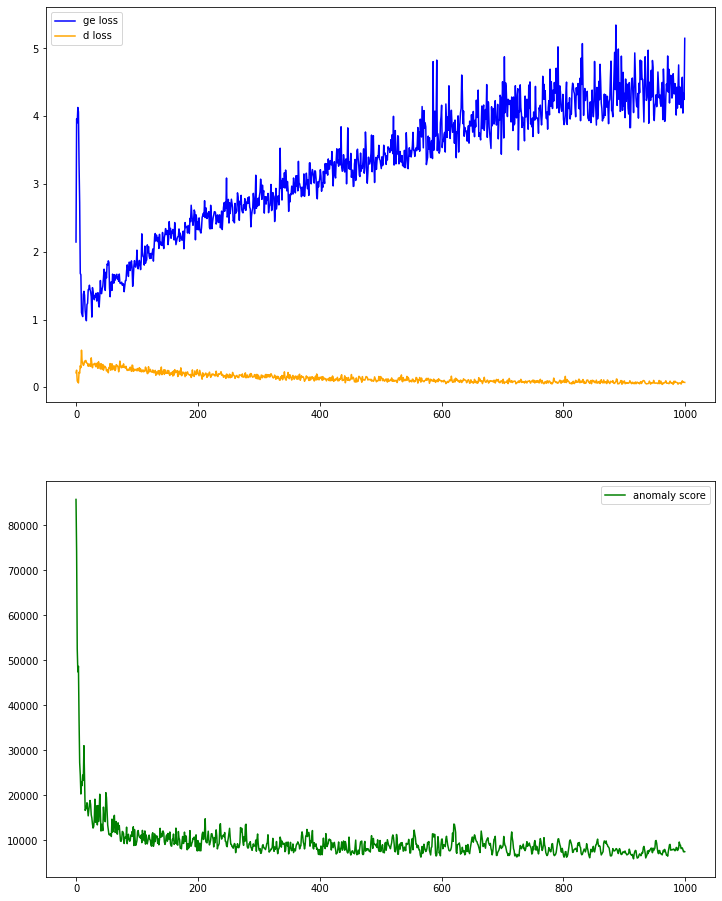

In [ ]:
plt.figure(figsize=(12, 8*2))

plt.subplot(211)
plt.plot(range(len(loss_ge_list)), loss_ge_list, label="ge loss",color="blue")
plt.legend()

plt.plot(range(len(loss_d_list)), loss_d_list, label="d loss",color="orange")
plt.legend()
plt.subplot(212)
plt.plot(range(len(anomaly_score_list)), anomaly_score_list, label="anomaly score",color="green")
plt.legend()


plt.show()

In [ ]:
LOAD_EPOCH = 900

model_G = Generator().to(device)
model_G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Generator_{LOAD_EPOCH}.pkl"))
model_G.eval()


model_E = Encoder().to(device)
model_E.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Encoder_{LOAD_EPOCH}.pkl"))
model_E.eval()

model_D = Discriminator().to(device)
model_D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Discriminator_{LOAD_EPOCH}.pkl"))
model_D.eval()
print("load model")

load model


In [ ]:
import random

random_image_size = 10

test_root_normal = './data/fruits-360/Test/Physalis/'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Anomaly_score: 1904.537


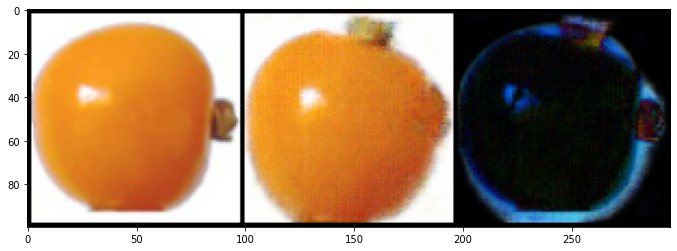

Anomaly_score: 1239.220


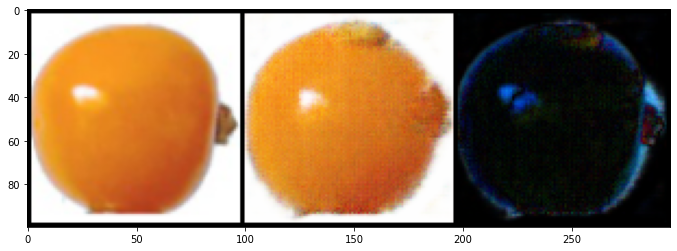

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anomaly_score: 892.422


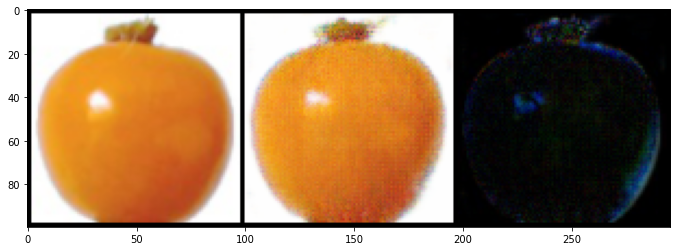

Anomaly_score: 904.024


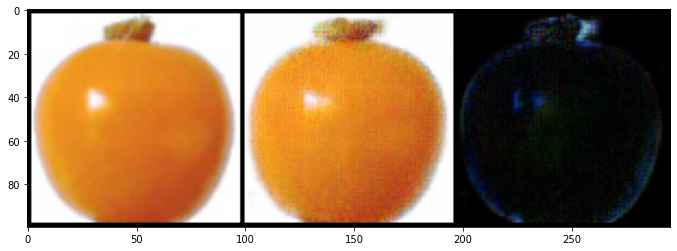

Anomaly_score: 798.999


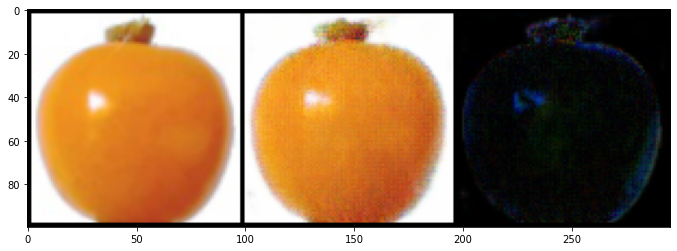

Anomaly_score: 970.719


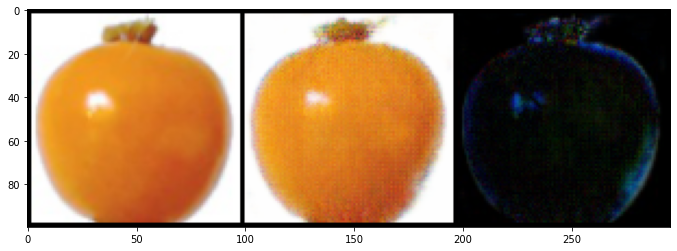

Anomaly_score: 2398.924


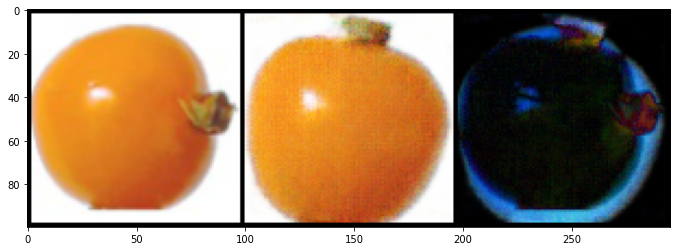

Anomaly_score: 1505.307


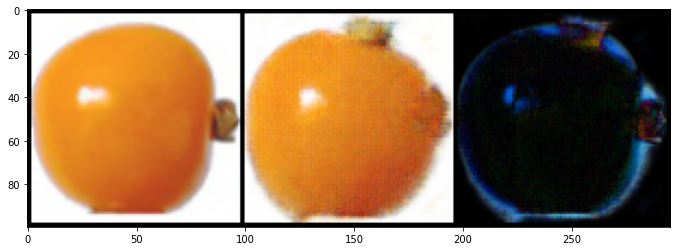

Anomaly_score: 1742.104


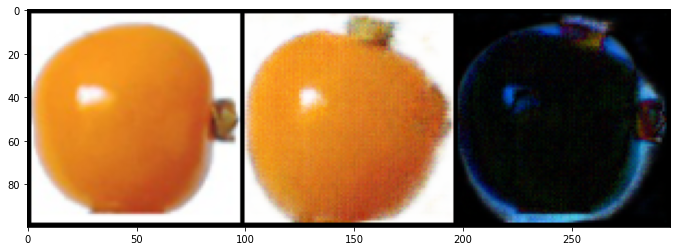

Anomaly_score: 877.628


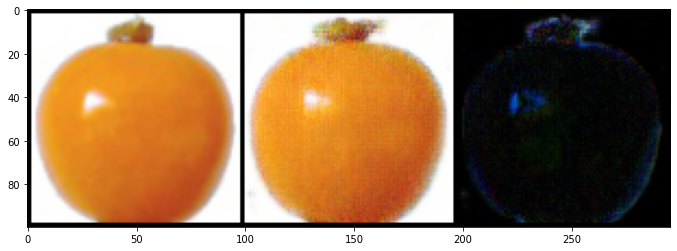

In [ ]:
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()


In [ ]:
normal_loss_list = []

for idx in range(len(test_dataset_normal)):

    x = test_dataset_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    normal_loss_list.append(loss)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
from glob import glob
import cv2

images_path = glob("./data/fruits-360/Test/Physalis/*.jpg")

def add_damage(image_path):
    
    folder = os.path.dirname(image_path)
    save_folder = folder + "_damaged"
    save_base_path = os.path.basename(image_path).replace(".jpg", "_damaged.jpg")
    save_path = os.path.join(save_folder, save_base_path)
    
    os.makedirs(save_folder, exist_ok=True)
    
    image = cv2.imread(image_path)
    center_x = random.randint(20, 76)
    center_y = random.randint(20, 76)
    color_r = random.randint(0, 255)
    color_g = random.randint(0, 255)
    color_b = random.randint(0, 255)
    
    center = (center_x, center_y)
    color = (color_r, color_g, color_b)
    
    cv2.circle(image, center = center, radius = 10, color = color,thickness=-1)
    cv2.imwrite(save_path, image)
    
[add_damage(image_path) for image_path in images_path]

test_root_anomaly = './data/fruits-360/Test/Physalis_damaged/'
test_dataset_anomaly = LoadFromFolder(test_root_anomaly, transform=transform_dict["test"])

test_images_anomaly = random.sample(list(test_dataset_anomaly), random_image_size)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anomaly_score: 1547.868


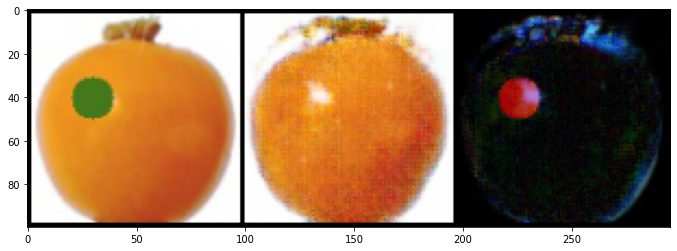

Anomaly_score: 1300.512


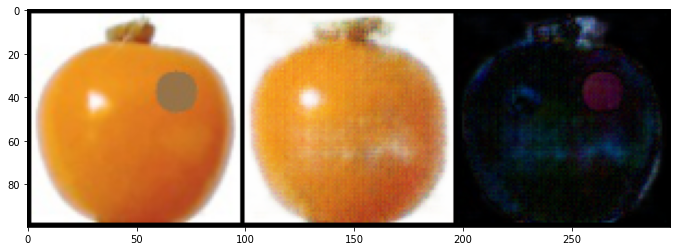

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anomaly_score: 3463.433


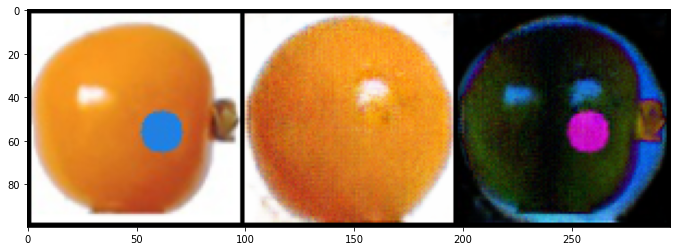

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anomaly_score: 1621.676


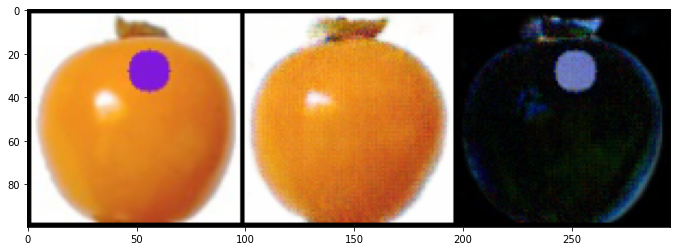

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anomaly_score: 1098.005


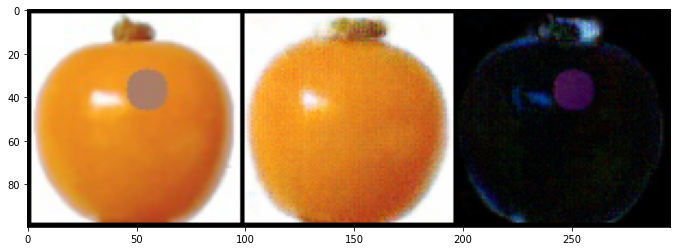

Anomaly_score: 1830.903


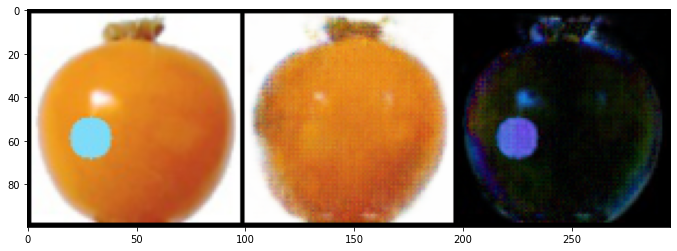

Anomaly_score: 1065.304


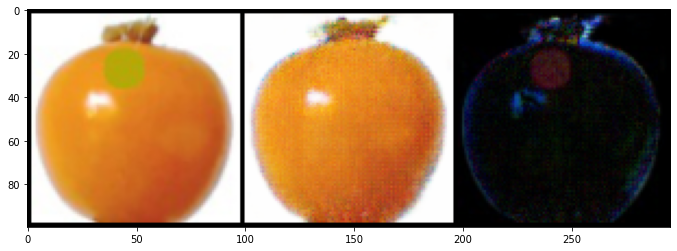

Anomaly_score: 2374.818


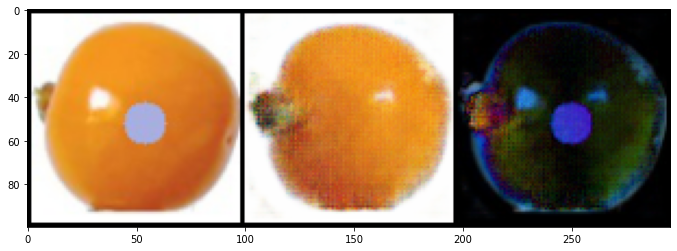

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anomaly_score: 1570.356


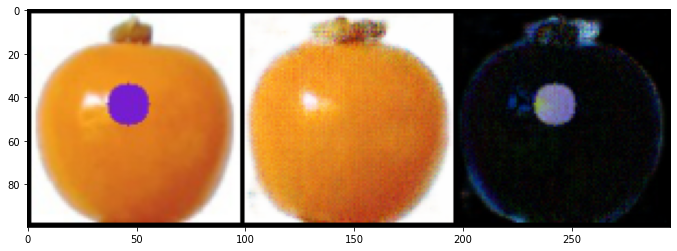

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Anomaly_score: 2425.672


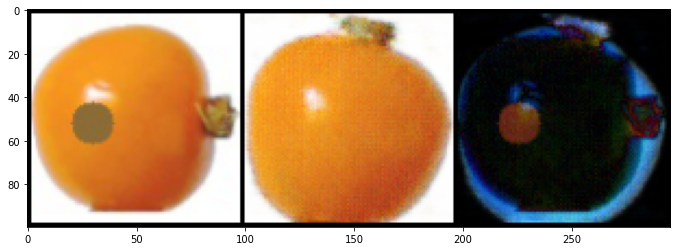

In [ ]:
for idx in range(len(test_images_anomaly)):

    x = test_images_anomaly[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()


In [ ]:
anomaly_loss_list = []

for idx in range(len(test_dataset_anomaly)):

    x = test_dataset_anomaly[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    anomaly_loss_list.append(loss)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


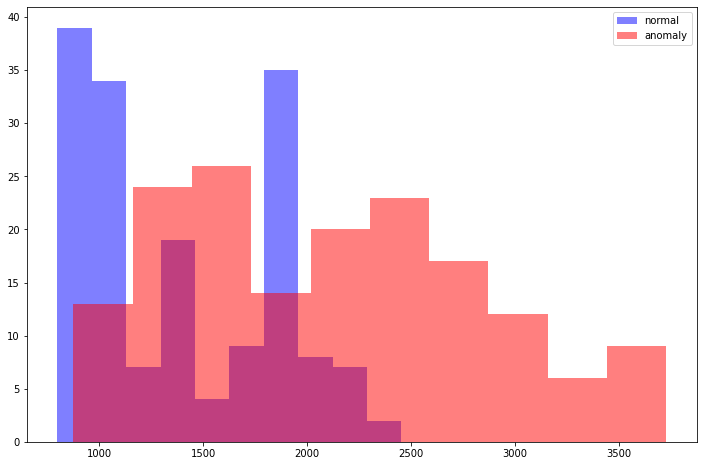

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(normal_loss_list, color="blue", alpha=0.5, bins=10, label="normal")
plt.hist(anomaly_loss_list, color="red", alpha=0.5, bins=10, label="anomaly")

plt.legend()
plt.show()